In [26]:
# Librerias a importar
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [27]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#1. Carga y Exploración de Datos:
Cargar el dataset

In [28]:
# Importar API Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/kaggle.json/'
# Descargar el dataset
!kaggle datasets download -d "mirichoi0218/insurance" --force
!unzip -o insurance.zip
#Path en Google Drive para guardar el dataset
output_path = '/content/drive/MyDrive/Colab Notebooks/Modelos Regresión/dataset/insurance.csv'

# Importar DataFrame
data = pd.read_csv('insurance.csv')

# Guardar el DataFrame en el path
data.to_csv(output_path, index=False)

# Eliminar archivos descargados en /content
!rm insurance.csv insurance.zip
print("Archivos insurance.csv e insurance.zip eliminados del directorio /content.")

Dataset URL: https://www.kaggle.com/datasets/mirichoi0218/insurance
License(s): DbCL-1.0
  0% 0.00/16.0k [00:00<?, ?B/s]
100% 16.0k/16.0k [00:00<00:00, 63.3MB/s]
Archive:  insurance.zip
  inflating: insurance.csv           
Archivos insurance.csv e insurance.zip eliminados del directorio /content.


Realizar una exploración inicial para entender la estructura del dataset

In [29]:
# Exploración de datos
print(data.head())
print(data.describe())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


Identificar valores faltantes

In [30]:
# Hacemos copia del DataFrame
df=data.copy()

# Convertimos a minúsculas y quitamos espacios en blanco de las columnas
df.columns = df.columns.str.lower().str.strip()

# Convertimos a minúsculas y quitamos espacios en blanco de las columnas de tipo objeto
for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = df[col].str.lower().str.strip()

In [31]:
# Verificar por datos nulos
datos_null = df.isnull()
if datos_null.any().any():
    print("Cantidad de datos nulos por columna:\n", datos_null.sum())
else:
    print("No se encontró datos nulos")

No se encontró datos nulos


Verificar tipos de datos en columnas

In [32]:
print(df.info())
# Resultado: Tipos de Datos en columnas correctos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


Identificar valores únicos

In [33]:
# Verificamos valores únicos en las columas
for col in df.columns:
    print(f"\nDatos en la columa: '{col}':")
    print(df[col].unique())


Datos en la columa: 'age':
[19 18 28 33 32 31 46 37 60 25 62 23 56 27 52 30 34 59 63 55 22 26 35 24
 41 38 36 21 48 40 58 53 43 64 20 61 44 57 29 45 54 49 47 51 42 50 39]

Datos en la columa: 'sex':
['female' 'male']

Datos en la columa: 'bmi':
[27.9   33.77  33.    22.705 28.88  25.74  33.44  27.74  29.83  25.84
 26.22  26.29  34.4   39.82  42.13  24.6   30.78  23.845 40.3   35.3
 36.005 32.4   34.1   31.92  28.025 27.72  23.085 32.775 17.385 36.3
 35.6   26.315 28.6   28.31  36.4   20.425 32.965 20.8   36.67  39.9
 26.6   36.63  21.78  30.8   37.05  37.3   38.665 34.77  24.53  35.2
 35.625 33.63  28.    34.43  28.69  36.955 31.825 31.68  22.88  37.335
 27.36  33.66  24.7   25.935 22.42  28.9   39.1   36.19  23.98  24.75
 28.5   28.1   32.01  27.4   34.01  29.59  35.53  39.805 26.885 38.285
 37.62  41.23  34.8   22.895 31.16  27.2   26.98  39.49  24.795 31.3
 38.28  19.95  19.3   31.6   25.46  30.115 29.92  27.5   28.4   30.875
 27.94  35.09  29.7   35.72  32.205 28.595 49.06  27.17 

Identificar inconsistencia en datos categóricos

In [34]:
# No se identificaron datos con inconsistencia

Identificar valores duplicados

In [35]:
# Buscar datos duplicados
datos_duplicados = df.duplicated()
if datos_duplicados.any():
    print("Cantidad de datos duplicados: ", datos_duplicados.sum())
else:
    print("No se encontró datos duplicados")

Cantidad de datos duplicados:  1


Identificar valores outliers

In [36]:
# Función para identificar valores outliers usando el método IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Identificar outliers en columna numéricas
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()

# Excluir la columna 'outcome'
if 'outcome' in numerical_columns:
  numerical_columns.remove('outcome')

print("\nIdentificar outliers usando el método IQR:")
for col in numerical_columns:
    outliers = detect_outliers_iqr(df, col)
    if not outliers.empty:
        print(f"Outliers en columna '{col}':")
        print(outliers[[col]])
        print("-" * 30)


Identificar outliers usando el método IQR:
Outliers en columna 'bmi':
        bmi
116   49.06
286   48.07
401   47.52
543   47.41
847   50.38
860   47.60
1047  52.58
1088  47.74
1317  53.13
------------------------------
Outliers en columna 'charges':
          charges
14    39611.75770
19    36837.46700
23    37701.87680
29    38711.00000
30    35585.57600
...           ...
1300  62592.87309
1301  46718.16325
1303  37829.72420
1313  36397.57600
1323  43896.37630

[139 rows x 1 columns]
------------------------------


#2. Limpieza y Preprocesamiento:

Eliminar columnas innecesarias

In [37]:
# No se consideró eliminar columnas del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Manejar inconsistencia en datos categóricos

In [38]:
# No hay datos con inconsistencia en dataset

Eliminar duplicados

In [39]:
# Eliminar filas duplicadas
df_cleaned = df.drop_duplicates()

# Verificar si se eliminaron los duplicados
print("\nDespués de eliminar duplicados:")
datos_duplicados_cleaned = df_cleaned.duplicated()
if datos_duplicados_cleaned.any():
    print("Cantidad de datos duplicados restantes: ", datos_duplicados_cleaned.sum())
else:
    print("No se encontró datos duplicados restantes")

# Actualizar df con el dataframe limpio
df = df_cleaned

print("\nInformación del DataFrame después de eliminar duplicados:")
df.info()


Después de eliminar duplicados:
No se encontró datos duplicados restantes

Información del DataFrame después de eliminar duplicados:
<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


Manejo de valores faltantes

In [40]:
# No hay datos faltantes en el dataframe

Manejar valores outliers

In [41]:
# Encontrados valores outliers en las columnas 'charges' y 'bmi'. No se manejará por ser valores de la realidad que se estudia.

##2. Exploración de Datos:
Crear visualizaciones univariadas y multivariadas

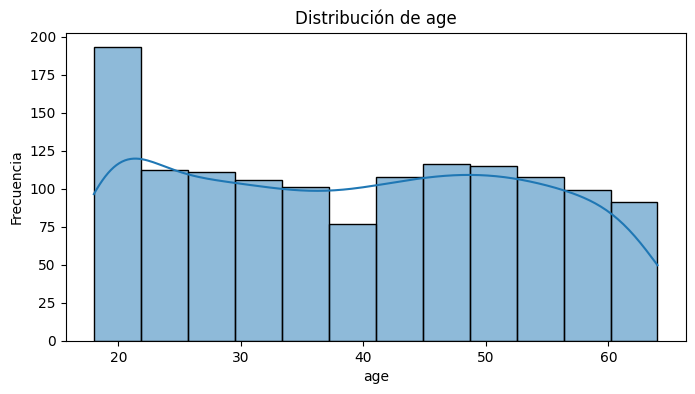

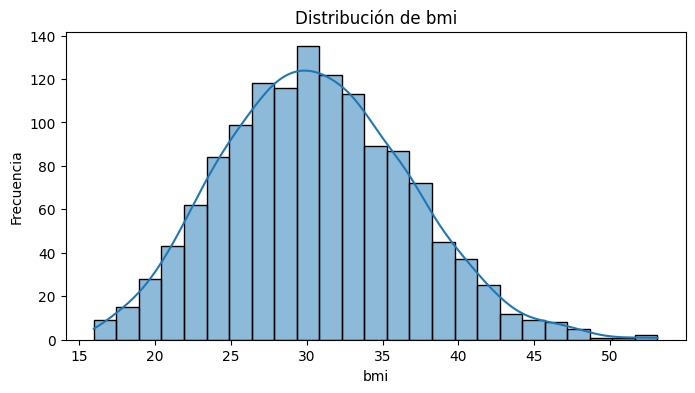

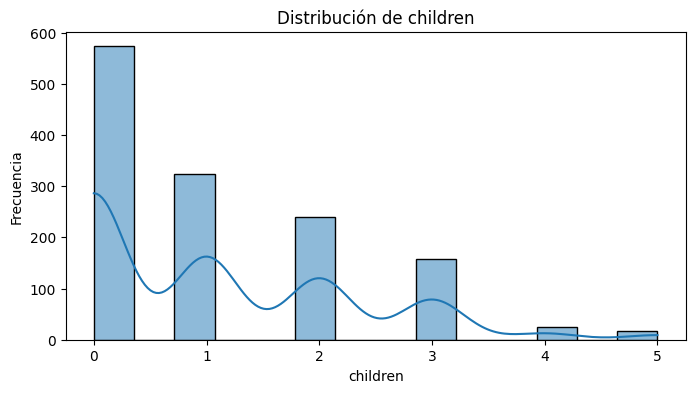

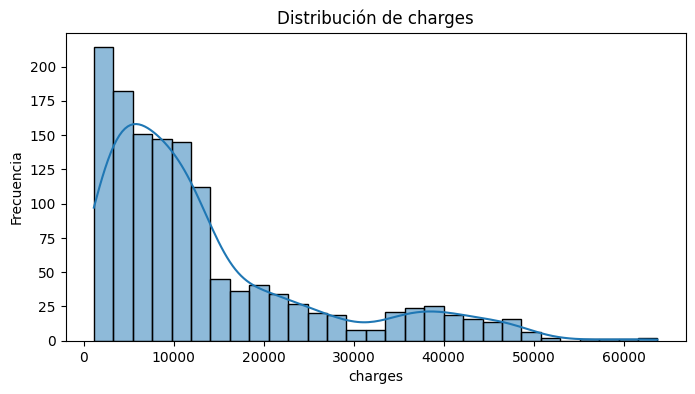

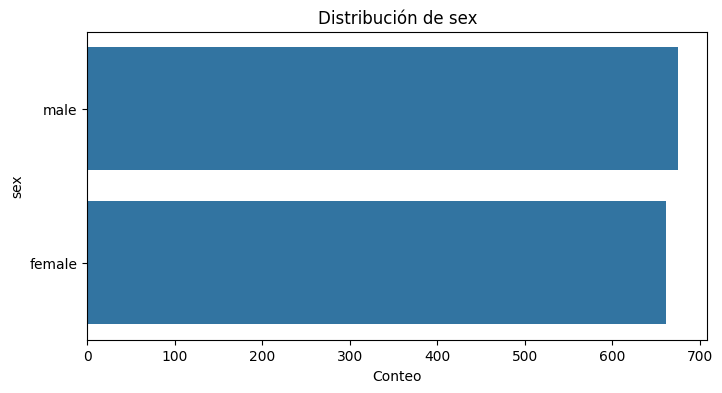

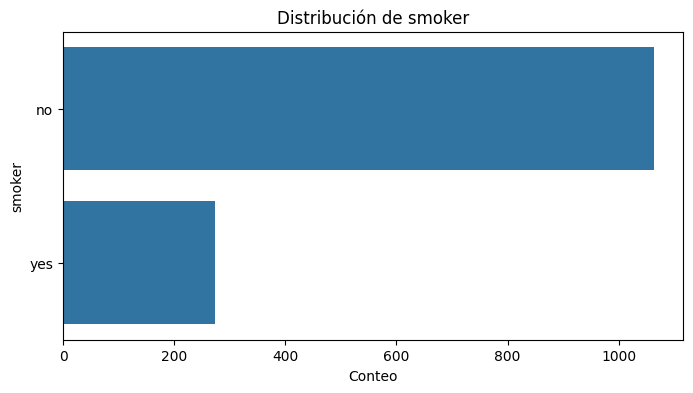

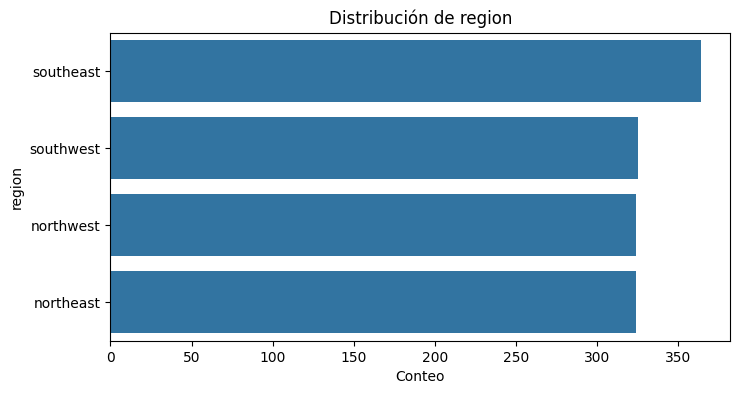

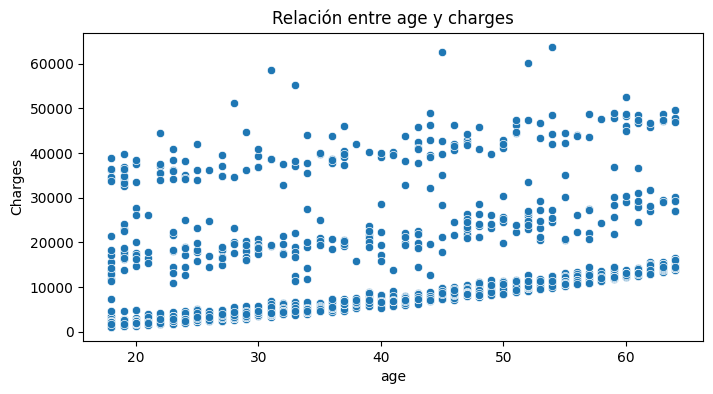

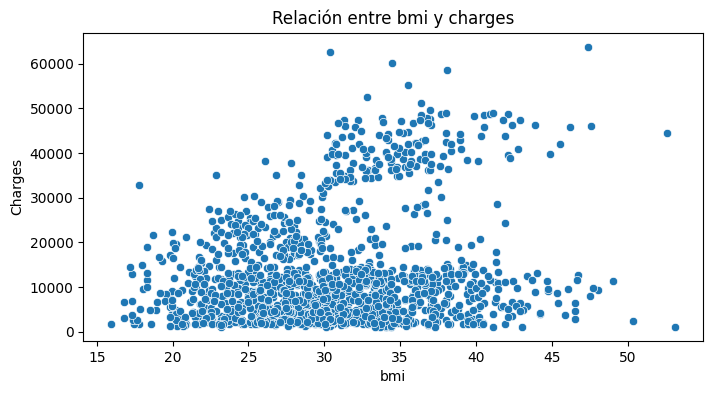

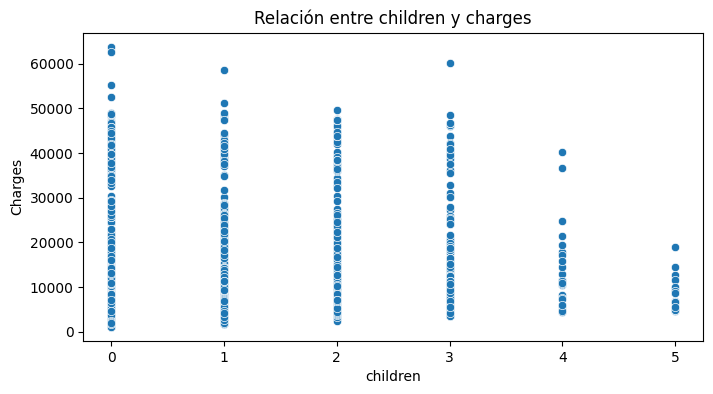

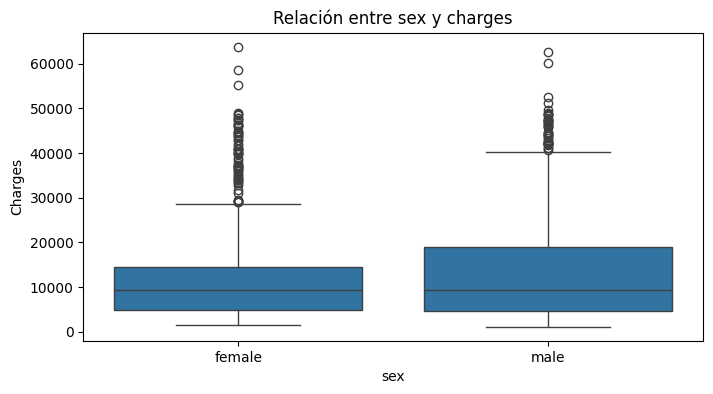

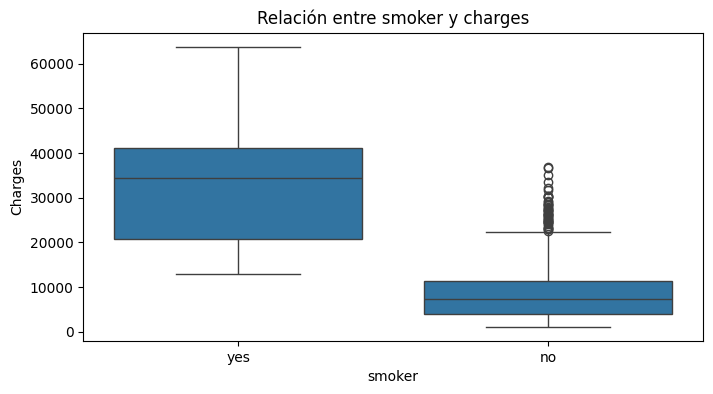

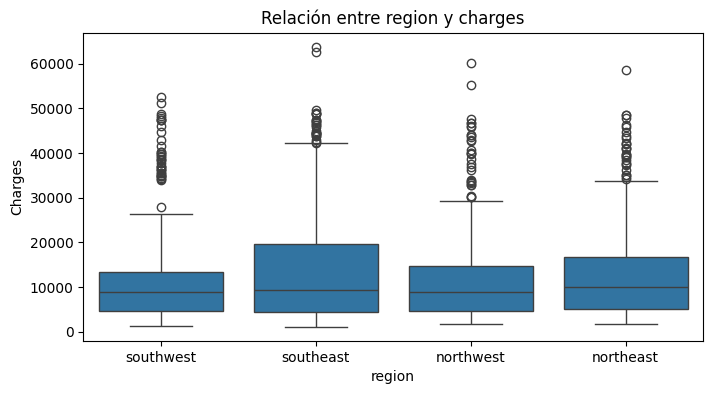

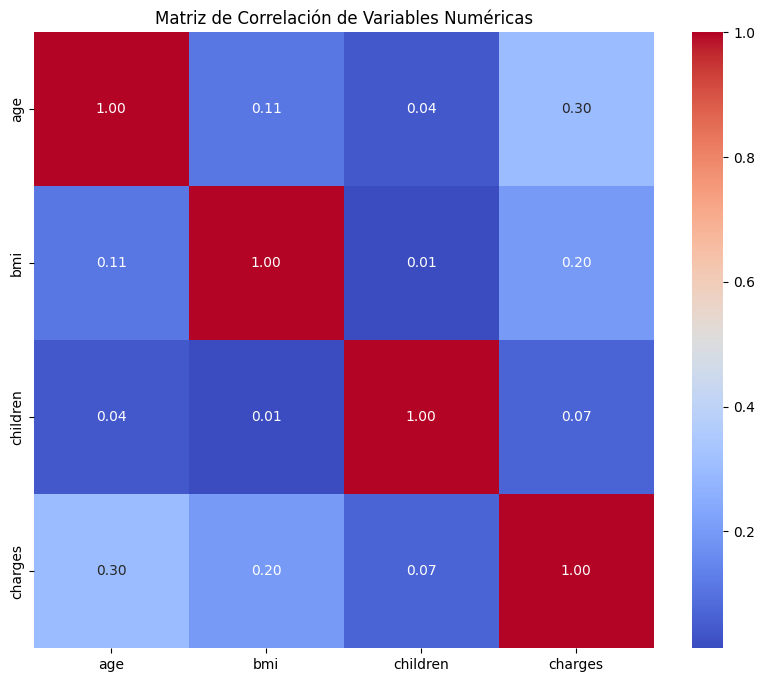

In [42]:
# Visualización univariada para variables numéricas
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

# Visualización univariada para variables categóricas
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=df[col], order = df[col].value_counts().index)
    plt.title(f'Distribución de {col}')
    plt.xlabel('Conteo')
    plt.ylabel(col)
    plt.show()

# Visualización multivariada: Relación entre 'charges' y otras variables numéricas
for col in numerical_cols:
    if col != 'charges':
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=df[col], y=df['charges'])
        plt.title(f'Relación entre {col} y charges')
        plt.xlabel(col)
        plt.ylabel('Charges')
        plt.show()

# Visualización multivariada: Relación entre 'charges' y variables categóricas
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col], y=df['charges'])
    plt.title(f'Relación entre {col} y charges')
    plt.xlabel(col)
    plt.ylabel('Charges')
    plt.show()

# Visualización multivariada: Matriz de correlación para variables numéricas
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

Explicación de los gráficos

* Los gráficos generados nos permiten entender la distribución de las variables y las relaciones entre ellas.

**Histogramas (Distribución Univariada Numérica):**
* Estos gráficos muestran la frecuencia con la que aparecen los valores de cada variable numérica.
* La curva KDE (Estimación de Densidad del Kernel) proporciona una estimación suavizada de la distribución.
* Nos ayuda a identificar la forma de la distribución (simétrica, sesgada), la presencia de múltiples picos (modas) y el rango de valores.

**Gráficos de Barras (Distribución Univariada Categórica):**
* Estos gráficos muestran el conteo de ocurrencias para cada categoría en las variables categóricas.
* Nos ayuda a ver la proporción de cada categoría y si hay desbalance en las clases.

**Gráficos de Dispersión (Relación entre 'charges' y Variables Numéricas):**
* Estos gráficos muestran la relación entre 'charges' y cada una de las otras variables numéricas.
* Cada punto representa un individuo, con su valor en el eje x y su 'charges' en el eje y.
* Nos ayuda a identificar si existe una correlación lineal o no lineal entre las variables.
* El gráfico de dispersión entre 'bmi' y 'charges' puede mostrar si a mayor IMC, hay mayores cargos.

**Boxplots (Relación entre 'charges' y Variables Categóricas):**
* Estos gráficos muestran la distribución de 'charges' para cada categoría de las variables categóricas.
* La caja representa el rango intercuartílico (IQR), la línea central es la mediana, y los "bigotes" extienden hasta 1.5 veces el IQR desde los cuartiles. Los puntos individuales fuera de los bigotes son considerados posibles outliers.
* Nos ayuda a comparar la distribución de 'charges' entre diferentes grupos categóricos.
* El boxplot de 'smoker' y 'charges' puede mostrar si los fumadores tienen significativamente mayores cargos que los no fumadores.

**Matriz de Correlación (Relación entre Variables Numéricas):**
* Este mapa de calor muestra el coeficiente de correlación de Pearson entre pares de variables numéricas.
* Los valores varían de -1 a 1, donde 1 indica una correlación positiva perfecta, -1 una correlación negativa perfecta, y 0 ninguna correlación lineal.
* El color indica la fuerza y dirección de la correlación (cmap='coolwarm' suele usar azul para correlaciones negativas y rojo para positivas, con tonos más intensos para correlaciones más fuertes).
* Nos ayuda a identificar qué variables numéricas están fuertemente correlacionadas entre sí. Por ejemplo, una correlación alta entre 'age' y 'charges' sugeriría que la edad es un factor importante en los cargos de seguro.


Calcular estadísticas descriptivas

In [43]:
print("\nEstadísticas descriptivas detalladas por columna:")
print("\nResumen general de estadísticas descriptivas:")
print(df.describe(include='all'))


Estadísticas descriptivas detalladas por columna:

Resumen general de estadísticas descriptivas:
                age   sex          bmi     children smoker     region  \
count   1337.000000  1337  1337.000000  1337.000000   1337       1337   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   675          NaN          NaN   1063        364   
mean      39.222139   NaN    30.663452     1.095737    NaN        NaN   
std       14.044333   NaN     6.100468     1.205571    NaN        NaN   
min       18.000000   NaN    15.960000     0.000000    NaN        NaN   
25%       27.000000   NaN    26.290000     0.000000    NaN        NaN   
50%       39.000000   NaN    30.400000     1.000000    NaN        NaN   
75%       51.000000   NaN    34.700000     2.000000    NaN        NaN   
max       64.000000   NaN    53.130000     5.000000    NaN        NaN   

             charges  
co

#3. Implementación de Modelos:

Uso de ColumnTransformer y Pipeline

In [44]:
# Cálculo de promedio de columna 'charges'
mean_charges = df['charges'].mean()
# Convertir columna 'charges' a binaria
df['bin_charge'] = (df['charges'] > mean_charges).astype(int)

# Cargar el conjunto de datos
X = df.drop(['charges', 'bin_charge'], axis=1)
y = df['bin_charge']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Seleccionar columnas numéricas para escalar
numeric_features = X.select_dtypes(include=np.number).columns.tolist()

# Identificar las columnas categóricas
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Crear transformadores para cada subconjunto de columnas
# Escalar las características numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Realizar transformaciones necesarias para las características categóricas
# Usar OneHotEncoder para variables nominales
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Crear un ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
],
    remainder='passthrough'
)

## Modelo Regresión Logística

Evaluación inicial con Cross-Validation para Regresión Logística:
Accuracy: 0.8868 (+/- 0.0273)
ROC AUC: 0.9013 (+/- 0.0415)

Optimizando Hiperparámetros con GridSearchCV para Regresión Logística:
Mejores Parámetros (GridSearchCV): {'classifier__C': 100, 'classifier__penalty': 'l1'}
Mejor valor Cross-Validation Accuracy (GridSearchCV): 0.8893

Métricas de evaluación para el mejor modelo (GridSearchCV) para Regresión Logística:
Accuracy: 0.9030
Precision: 1.0000
Recall: 0.6977
F1-Score: 0.8219
ROC AUC: 0.9311


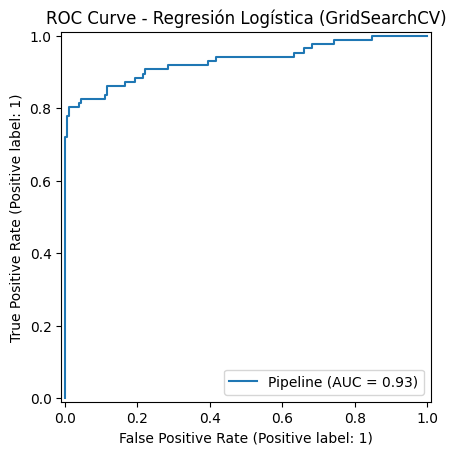


Optimizando Hiperparámetros con RandomizedSearchCV para Regresión Logística:
Mejores Parámetros (RandomizedSearchCV): {'classifier__penalty': 'l1', 'classifier__C': np.float64(100.0)}
Mejor valor Cross-Validation Accuracy (RandomizedSearchCV): 0.8893

Métricas de evaluación para el mejor modelo (GridSearchCV) para Regresión Logística:
Accuracy: 0.9030
Precision: 1.0000
Recall: 0.6977
F1-Score: 0.8219
ROC AUC: 0.9311

Matriz de Confusión GridSearchCV:
[[182   0]
 [ 26  60]]

Matriz de Confusión RandomizedSearchCV:
[[182   0]
 [ 26  60]]


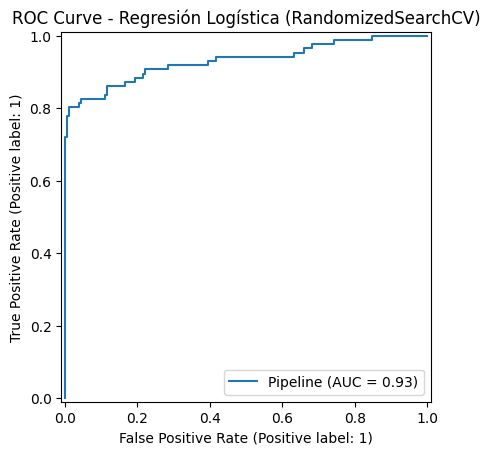


Comparar resultados entre GridSearchCV y RandomizedSearchCV:
GridSearchCV Mejor Accuracy: 0.8893 con parámetros: {'classifier__C': 100, 'classifier__penalty': 'l1'}
RandomizedSearchCV Mejor Accuracy: 0.8893 con parámetros: {'classifier__penalty': 'l1', 'classifier__C': np.float64(100.0)}


In [45]:
# Crear pipeline para Regresión Logística
pipeline_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

# Evaluación inicial con Cross-Validation
print("Evaluación inicial con Cross-Validation para Regresión Logística:")
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(pipeline_logreg, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Evaluar métricas de ROC AUC usando cross_val_score
roc_auc_scores = cross_val_score(pipeline_logreg, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"ROC AUC: {roc_auc_scores.mean():.4f} (+/- {roc_auc_scores.std():.4f})")


# Definir la grilla de hiperparámetros a tunear
print("\nOptimizando Hiperparámetros con GridSearchCV para Regresión Logística:")
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
}

# Configurar GridSearchCV para encontrar la mejor combinación de hiperparámetros
grid_search = GridSearchCV(pipeline_logreg, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Mejores Parámetros (GridSearchCV): {grid_search.best_params_}")
print(f"Mejor valor Cross-Validation Accuracy (GridSearchCV): {grid_search.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_logreg_model_gs = grid_search.best_estimator_
y_pred_gs = best_logreg_model_gs.predict(X_test)
y_prob_gs = best_logreg_model_gs.predict_proba(X_test)[:, 1]

accuracy_gs = accuracy_score(y_test, y_pred_gs)
precision_gs = precision_score(y_test, y_pred_gs)
recall_gs = recall_score(y_test, y_pred_gs)
f1_gs = f1_score(y_test, y_pred_gs)
roc_auc_gs = roc_auc_score(y_test, y_prob_gs)


# Calcular métricas de evaluación
print("\nMétricas de evaluación para el mejor modelo (GridSearchCV) para Regresión Logística:")
print(f"Accuracy: {accuracy_gs:.4f}")
print(f"Precision: {precision_gs:.4f}")
print(f"Recall: {recall_gs:.4f}")
print(f"F1-Score: {f1_gs:.4f}")
print(f"ROC AUC: {roc_auc_gs:.4f}")

# Plot ROC Curve
RocCurveDisplay.from_estimator(best_logreg_model_gs, X_test, y_test)
plt.title('ROC Curve - Regresión Logística (GridSearchCV)')
plt.show()

# Implementar RandomizedSearchCV como método alternativo
print("\nOptimizando Hiperparámetros con RandomizedSearchCV para Regresión Logística:")
param_distributions = {
    'classifier__C': np.logspace(-3, 2, 6),
    'classifier__penalty': ['l1', 'l2'],
}

# Configurar RandomizedSearchCV para encontrar la mejor combinación de hiperparámetros
random_search = RandomizedSearchCV(pipeline_logreg, param_distributions, n_iter=12, cv=cv, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print(f"Mejores Parámetros (RandomizedSearchCV): {random_search.best_params_}")
print(f"Mejor valor Cross-Validation Accuracy (RandomizedSearchCV): {random_search.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_logreg_model_rs = random_search.best_estimator_
y_pred_rs = best_logreg_model_rs.predict(X_test)
y_prob_rs = best_logreg_model_rs.predict_proba(X_test)[:, 1]

accuracy_rs = accuracy_score(y_test, y_pred_rs)
precision_rs = precision_score(y_test, y_pred_rs)
recall_rs = recall_score(y_test, y_pred_rs)
f1_rs = f1_score(y_test, y_pred_rs)
roc_auc_rs = roc_auc_score(y_test, y_prob_rs)

# Calcular métricas de evaluación
print("\nMétricas de evaluación para el mejor modelo (GridSearchCV) para Regresión Logística:")
print(f"Accuracy: {accuracy_rs:.4f}")
print(f"Precision: {precision_rs:.4f}")
print(f"Recall: {recall_rs:.4f}")
print(f"F1-Score: {f1_rs:.4f}")
print(f"ROC AUC: {roc_auc_rs:.4f}")

# Matriz de confusión GridSearchCV
cm_gs = confusion_matrix(y_test, y_pred_gs)
print("\nMatriz de Confusión GridSearchCV:")
print(cm_gs)

# Matriz de confusión RandomizedSearchCV
cm_rs = confusion_matrix(y_test, y_pred_rs)
print("\nMatriz de Confusión RandomizedSearchCV:")
print(cm_rs)

# Plot ROC Curve para el RandomizedSearchCV mejor modelo
RocCurveDisplay.from_estimator(best_logreg_model_rs, X_test, y_test)
plt.title('ROC Curve - Regresión Logística (RandomizedSearchCV)')
plt.show()

# Comparar resultados entre GridSearchCV y RandomizedSearchCV
print("\nComparar resultados entre GridSearchCV y RandomizedSearchCV:")
print(f"GridSearchCV Mejor Accuracy: {grid_search.best_score_:.4f} con parámetros: {grid_search.best_params_}")
print(f"RandomizedSearchCV Mejor Accuracy: {random_search.best_score_:.4f} con parámetros: {random_search.best_params_}")

##Modelo de K-Nearest Neighbors (KNN)


Evaluación inicial con Cross-Validation para KNN:
Accuracy: 0.8781 (+/- 0.0299)
ROC AUC: 0.8809 (+/- 0.0450)

Optimizando Hiperparámetros con GridSearchCV para KNN:
Mejores Parámetros (GridSearchCV): {'classifier__n_neighbors': 19, 'classifier__p': 1, 'classifier__weights': 'distance'}
Mejor valor Cross-Validation Accuracy (GridSearchCV): 0.8915

Métricas de evaluación para el mejor modelo (GridSearchCV) para KNN:
Accuracy: 0.8955
Precision: 0.9394
Recall: 0.7209
F1-Score: 0.8158
ROC AUC: 0.8985


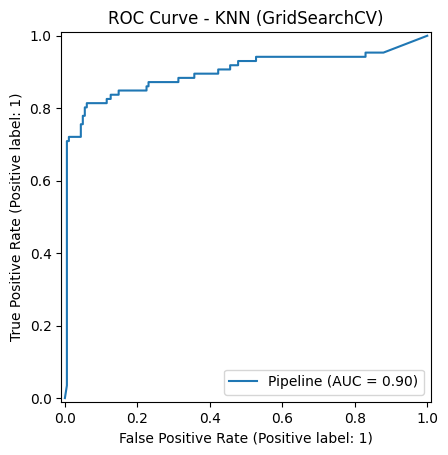


Optimizando Hiperparámetros con RandomizedSearchCV para KNN:
Mejores Parámetros (RandomizedSearchCV): {'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 19}
Mejor valor Cross-Validation Accuracy (RandomizedSearchCV): 0.8915

Métricas de evaluación para el mejor modelo (RandomizedSearchCV) para KNN:
Accuracy: 0.8955
Precision: 0.9394
Recall: 0.7209
F1-Score: 0.8158
ROC AUC: 0.8985

Matriz de Confusión GridSearchCV:
[[178   4]
 [ 24  62]]

Matriz de Confusión RandomizedSearchCV:
[[178   4]
 [ 24  62]]


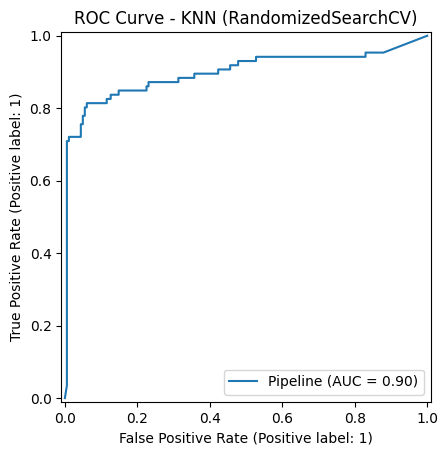


Comparar resultados entre GridSearchCV y RandomizedSearchCV:
GridSearchCV Best Accuracy: 0.8915 con parámetros: {'classifier__n_neighbors': 19, 'classifier__p': 1, 'classifier__weights': 'distance'}
RandomizedSearchCV Best Accuracy: 0.8915 con parámetros: {'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 19}


In [46]:
# Pipeline y preprocesamiento del modelo KNN
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', KNeighborsClassifier())])

# Evaluación inicial con Cross-Validation
print("\nEvaluación inicial con Cross-Validation para KNN:")
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores_knn = cross_val_score(pipeline_knn, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Accuracy: {scores_knn.mean():.4f} (+/- {scores_knn.std():.4f})")

# Evaluar métricas de ROC AUC usando cross_val_score
roc_auc_scores_knn = cross_val_score(pipeline_knn, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"ROC AUC: {roc_auc_scores_knn.mean():.4f} (+/- {roc_auc_scores_knn.std():.4f})")

# Definir la grilla de hiperparámetros a tunear
print("\nOptimizando Hiperparámetros con GridSearchCV para KNN:")
param_grid_knn = {
    'classifier__n_neighbors': list(range(1, 31)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2] # 1 Manhattan, 2 Euclidean
}

# Configurar GridSearchCV para encontrar la mejor combinación de hiperparámetros
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

print(f"Mejores Parámetros (GridSearchCV): {grid_search_knn.best_params_}")
print(f"Mejor valor Cross-Validation Accuracy (GridSearchCV): {grid_search_knn.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_knn_model_gs = grid_search_knn.best_estimator_
y_pred_knn_gs = best_knn_model_gs.predict(X_test)
y_prob_knn_gs = best_knn_model_gs.predict_proba(X_test)[:, 1]

accuracy_knn_gs = accuracy_score(y_test, y_pred_knn_gs)
precision_knn_gs = precision_score(y_test, y_pred_knn_gs)
recall_knn_gs = recall_score(y_test, y_pred_knn_gs)
f1_knn_gs = f1_score(y_test, y_pred_knn_gs)
roc_auc_knn_gs = roc_auc_score(y_test, y_prob_knn_gs)

# Calcular métricas de evaluación
print("\nMétricas de evaluación para el mejor modelo (GridSearchCV) para KNN:")
print(f"Accuracy: {accuracy_knn_gs:.4f}")
print(f"Precision: {precision_knn_gs:.4f}")
print(f"Recall: {recall_knn_gs:.4f}")
print(f"F1-Score: {f1_knn_gs:.4f}")
print(f"ROC AUC: {roc_auc_knn_gs:.4f}")

# Plot ROC Curve
RocCurveDisplay.from_estimator(best_knn_model_gs, X_test, y_test)
plt.title('ROC Curve - KNN (GridSearchCV)')
plt.show()

# Implementar RandomizedSearchCV como método alternativo
print("\nOptimizando Hiperparámetros con RandomizedSearchCV para KNN:")
param_distributions_knn = {
    'classifier__n_neighbors': list(range(1, 31)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

# Configurar RandomizedSearchCV para encontrar la mejor combinación de hiperparámetros
random_search_knn = RandomizedSearchCV(pipeline_knn, param_distributions_knn, n_iter=12, cv=cv, scoring='accuracy', random_state=42, n_jobs=-1)
random_search_knn.fit(X_train, y_train)

print(f"Mejores Parámetros (RandomizedSearchCV): {random_search_knn.best_params_}")
print(f"Mejor valor Cross-Validation Accuracy (RandomizedSearchCV): {random_search_knn.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_knn_model_rs = random_search_knn.best_estimator_
y_pred_knn_rs = best_knn_model_rs.predict(X_test)
y_prob_knn_rs = best_knn_model_rs.predict_proba(X_test)[:, 1]

accuracy_knn_rs = accuracy_score(y_test, y_pred_knn_rs)
precision_knn_rs = precision_score(y_test, y_pred_knn_rs)
recall_knn_rs = recall_score(y_test, y_pred_knn_rs)
f1_knn_rs = f1_score(y_test, y_pred_knn_rs)
roc_auc_knn_rs = roc_auc_score(y_test, y_prob_knn_rs)

print("\nMétricas de evaluación para el mejor modelo (RandomizedSearchCV) para KNN:")
print(f"Accuracy: {accuracy_knn_rs:.4f}")
print(f"Precision: {precision_knn_rs:.4f}")
print(f"Recall: {recall_knn_rs:.4f}")
print(f"F1-Score: {f1_knn_rs:.4f}")
print(f"ROC AUC: {roc_auc_knn_rs:.4f}")

# Matriz de confusión GridSearchCV
cm_knn_gs = confusion_matrix(y_test, y_pred_knn_gs)
print("\nMatriz de Confusión GridSearchCV:")
print(cm_knn_gs)

# Matriz de confusión RandomizedSearchCV
cm_knn_rs = confusion_matrix(y_test, y_pred_knn_rs)
print("\nMatriz de Confusión RandomizedSearchCV:")
print(cm_knn_rs)

# Plot ROC Curve para el RandomizedSearchCV mejor modelo
RocCurveDisplay.from_estimator(best_knn_model_rs, X_test, y_test)
plt.title('ROC Curve - KNN (RandomizedSearchCV)')
plt.show()

# Comparar resultados entre GridSearchCV y RandomizedSearchCV
print("\nComparar resultados entre GridSearchCV y RandomizedSearchCV:")
print(f"GridSearchCV Best Accuracy: {grid_search_knn.best_score_:.4f} con parámetros: {grid_search_knn.best_params_}")
print(f"RandomizedSearchCV Best Accuracy: {random_search_knn.best_score_:.4f} con parámetros: {random_search_knn.best_params_}")

##Modelo de Árbol de Decisión


Evaluación inicial con Cross-Validation para modelo de Árbol de Decisión:
Accuracy: 0.8534 (+/- 0.0331)
ROC AUC: 0.8381 (+/- 0.0394)

Optimizando Hiperparámetros con GridSearchCV para modelo de Árbol de Decisión:
Mejores Parámetros (GridSearchCV): {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Mejor valor Cross-Validation Accuracy (GridSearchCV): 0.9267

Métricas de evaluación para el mejor modelo (GridSearchCV) para modelo de Árbol de Decisión:
Accuracy: 0.9366
Precision: 0.9726
Recall: 0.8256
F1-Score: 0.8931
ROC AUC: 0.9153


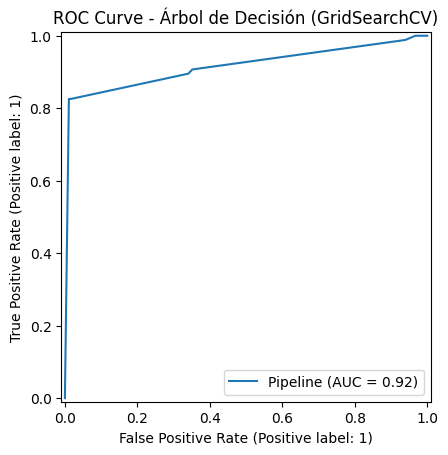


Optimizando Hiperparámetros con RandomizedSearchCV para modelo de Árbol de Decisión:
Mejores Parámetros (RandomizedSearchCV): {'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy'}
Mejor valor Cross-Validation Accuracy (RandomizedSearchCV): 0.9251

Métricas de evaluación para el mejor modelo (RandomizedSearchCV) para modelo de Árbol de Decisión:
Accuracy: 0.9328
Precision: 0.9722
Recall: 0.8140
F1-Score: 0.8861
ROC AUC: 0.9182

Matriz de Confusión GridSearchCV:
[[180   2]
 [ 15  71]]

Matriz de Confusión RandomizedSearchCV:
[[180   2]
 [ 16  70]]


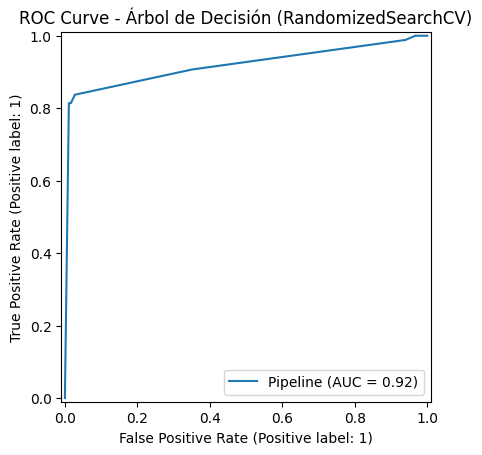


Comparar resultados entre GridSearchCV y RandomizedSearchCV:
GridSearchCV Best Accuracy: 0.9267 con parámetros: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
RandomizedSearchCV Best Accuracy: 0.9251 con parámetros: {'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy'}


In [47]:
# Pipeline y preprocesamiento del modelo Árbol de Decisión
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', DecisionTreeClassifier(random_state=42))])

# Evaluación inicial con Cross-Validation
print("\nEvaluación inicial con Cross-Validation para modelo de Árbol de Decisión:")
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores_dt = cross_val_score(pipeline_dt, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Accuracy: {scores_dt.mean():.4f} (+/- {scores_dt.std():.4f})")

# Evaluar métricas de ROC AUC usando cross_val_score
roc_auc_scores_dt = cross_val_score(pipeline_dt, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"ROC AUC: {roc_auc_scores_dt.mean():.4f} (+/- {roc_auc_scores_dt.std():.4f})")

# Definir la grilla de hiperparámetros a tunear
print("\nOptimizando Hiperparámetros con GridSearchCV para modelo de Árbol de Decisión:")
param_grid_dt = {
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

# Configurar GridSearchCV para encontrar la mejor combinación de hiperparámetros
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

print(f"Mejores Parámetros (GridSearchCV): {grid_search_dt.best_params_}")
print(f"Mejor valor Cross-Validation Accuracy (GridSearchCV): {grid_search_dt.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_dt_model_gs = grid_search_dt.best_estimator_
y_pred_dt_gs = best_dt_model_gs.predict(X_test)
y_prob_dt_gs = best_dt_model_gs.predict_proba(X_test)[:, 1]

accuracy_dt_gs = accuracy_score(y_test, y_pred_dt_gs)
precision_dt_gs = precision_score(y_test, y_pred_dt_gs)
recall_dt_gs = recall_score(y_test, y_pred_dt_gs)
f1_dt_gs = f1_score(y_test, y_pred_dt_gs)
roc_auc_dt_gs = roc_auc_score(y_test, y_prob_dt_gs)

# Calcular métricas de evaluación
print("\nMétricas de evaluación para el mejor modelo (GridSearchCV) para modelo de Árbol de Decisión:")
print(f"Accuracy: {accuracy_dt_gs:.4f}")
print(f"Precision: {precision_dt_gs:.4f}")
print(f"Recall: {recall_dt_gs:.4f}")
print(f"F1-Score: {f1_dt_gs:.4f}")
print(f"ROC AUC: {roc_auc_dt_gs:.4f}")

# Plot ROC Curve
RocCurveDisplay.from_estimator(best_dt_model_gs, X_test, y_test)
plt.title('ROC Curve - Árbol de Decisión (GridSearchCV)')
plt.show()

# Implementar RandomizedSearchCV como método alternativo
print("\nOptimizando Hiperparámetros con RandomizedSearchCV para modelo de Árbol de Decisión:")
param_distributions_dt = {
    'classifier__max_depth': [None, 5, 10, 15, 20, 25, 30],
    'classifier__min_samples_split': [2, 5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 8, 16],
    'classifier__criterion': ['gini', 'entropy']
}

# Configurar RandomizedSearchCV para encontrar la mejor combinación de hiperparámetros
random_search_dt = RandomizedSearchCV(pipeline_dt, param_distributions_dt, n_iter=50, cv=cv, scoring='accuracy', random_state=42, n_jobs=-1)
random_search_dt.fit(X_train, y_train)

print(f"Mejores Parámetros (RandomizedSearchCV): {random_search_dt.best_params_}")
print(f"Mejor valor Cross-Validation Accuracy (RandomizedSearchCV): {random_search_dt.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de prueba
best_dt_model_rs = random_search_dt.best_estimator_
y_pred_dt_rs = best_dt_model_rs.predict(X_test)
y_prob_dt_rs = best_dt_model_rs.predict_proba(X_test)[:, 1]

accuracy_dt_rs = accuracy_score(y_test, y_pred_dt_rs)
precision_dt_rs = precision_score(y_test, y_pred_dt_rs)
recall_dt_rs = recall_score(y_test, y_pred_dt_rs)
f1_dt_rs = f1_score(y_test, y_pred_dt_rs)
roc_auc_dt_rs = roc_auc_score(y_test, y_prob_dt_rs)

print("\nMétricas de evaluación para el mejor modelo (RandomizedSearchCV) para modelo de Árbol de Decisión:")
print(f"Accuracy: {accuracy_dt_rs:.4f}")
print(f"Precision: {precision_dt_rs:.4f}")
print(f"Recall: {recall_dt_rs:.4f}")
print(f"F1-Score: {f1_dt_rs:.4f}")
print(f"ROC AUC: {roc_auc_dt_rs:.4f}")

# Matriz de confusión GridSearchCV
cm_dt_gs = confusion_matrix(y_test, y_pred_dt_gs)
print("\nMatriz de Confusión GridSearchCV:")
print(cm_dt_gs)

# Matriz de confusión RandomizedSearchCV
cm_dt_rs = confusion_matrix(y_test, y_pred_dt_rs)
print("\nMatriz de Confusión RandomizedSearchCV:")
print(cm_dt_rs)

# Plot ROC Curve para el RandomizedSearchCV mejor modelo
RocCurveDisplay.from_estimator(best_dt_model_rs, X_test, y_test)
plt.title('ROC Curve - Árbol de Decisión (RandomizedSearchCV)')
plt.show()

# Comparar resultados entre GridSearchCV y RandomizedSearchCV
print("\nComparar resultados entre GridSearchCV y RandomizedSearchCV:")
print(f"GridSearchCV Best Accuracy: {grid_search_dt.best_score_:.4f} con parámetros: {grid_search_dt.best_params_}")
print(f"RandomizedSearchCV Best Accuracy: {random_search_dt.best_score_:.4f} con parámetros: {random_search_dt.best_params_}")

Comparación de Rendimiento

Comparación de Rendimiento de los Modelos:
      Metric  Regresión Logística GridSearchCV  \
0   Accuracy                          0.902985   
1  Precision                          1.000000   
2     Recall                          0.697674   
3   F1-score                          0.821918   
4    ROC-AUC                          0.931127   

   Regresión Logística RandomizedSearchCV  KNN GridSearchCV  \
0                                0.902985          0.895522   
1                                1.000000          0.939394   
2                                0.697674          0.720930   
3                                0.821918          0.815789   
4                                0.931127          0.898511   

   KNN RandomizedSearchCV  Árbol de Decisión GridSearchCV  \
0                0.895522                        0.936567   
1                0.939394                        0.972603   
2                0.720930                        0.825581   
3                0.815789        

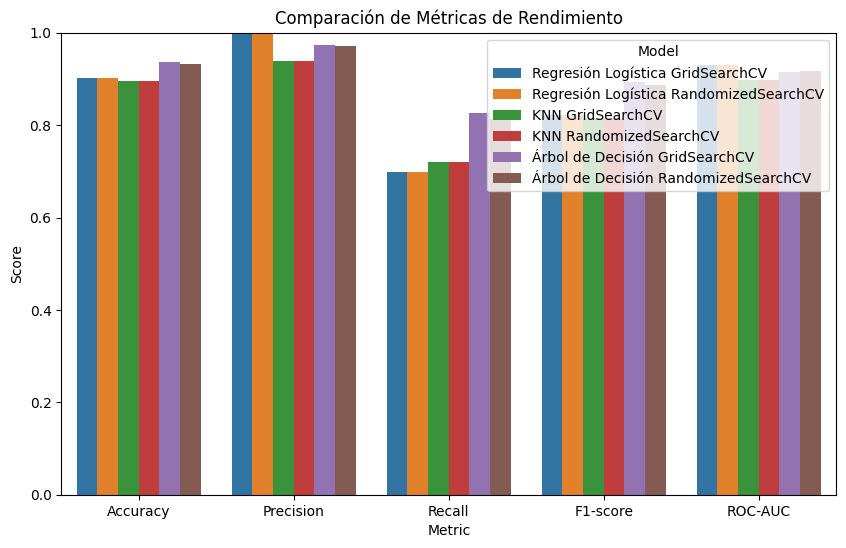

In [48]:
# Construir un DataFrame con las métricas para la comparación
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'Regresión Logística GridSearchCV': [accuracy_gs, precision_gs, recall_gs, f1_gs, roc_auc_gs],
    'Regresión Logística RandomizedSearchCV': [accuracy_rs, precision_rs, recall_rs, f1_rs, roc_auc_rs],

    'KNN GridSearchCV': [accuracy_knn_gs, precision_knn_gs, recall_knn_gs, f1_knn_gs, roc_auc_knn_gs],
    'KNN RandomizedSearchCV': [accuracy_knn_rs, precision_knn_rs, recall_knn_rs, f1_knn_rs, roc_auc_knn_rs],

    'Árbol de Decisión GridSearchCV': [accuracy_dt_gs, precision_dt_gs, recall_dt_gs, f1_dt_gs, roc_auc_dt_gs],
    'Árbol de Decisión RandomizedSearchCV': [accuracy_dt_rs, precision_dt_rs, recall_dt_rs, f1_dt_rs, roc_auc_dt_rs],
})

print("Comparación de Rendimiento de los Modelos:")
print(comparison_df)
print("-" * 40)



# Comparación usando gráfico bar plot
comparison_df_melted = comparison_df.melt(id_vars='Metric', var_name='Model', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_df_melted)
plt.title('Comparación de Métricas de Rendimiento')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

## Discusión sobre la Adecuación del Modelo y Conclusión

Para determinar la adecuación de los modelos, analizaremos las métricas de rendimiento obtenidas (Accuracy, Precision, Recall, F1-Score y ROC AUC) y las matrices de confusión para cada uno de los modelos optimizados con GridSearchCV y RandomizedSearchCV.

**Comparación de Rendimiento:**

Observando la tabla de comparación de rendimiento y los gráficos de métricas:

*   **Accuracy:** El modelo de Árbol de Decisión (GridSearchCV: 0.9366, RandomizedSearchCV: 0.9328) presenta la mayor precisión en general, seguido de la Regresión Logística (GridSearchCV y RandomizedSearchCV: 0.9030) y luego KNN (GridSearchCV y RandomizedSearchCV: 0.8955). Esto indica que el Árbol de Decisión clasifica correctamente una mayor proporción de instancias totales.

*   **Precision:** Tanto la Regresión Logística como el Árbol de Decisión alcanzan una precisión muy alta (cercana a 1.0000 para Regresión Logística y alrededor de 0.97 para Árbol de Decisión). Esto significa que, cuando predicen la clase positiva 'bin_charge', son muy acertados. KNN tiene una precisión ligeramente menor (alrededor de 0.939).

*   **Recall:** El Árbol de Decisión (GridSearchCV: 0.8256, RandomizedSearchCV: 0.8140) tiene el recall más alto, lo que significa que identifica una mayor proporción de las instancias positivas reales 'bin_charge'. Regresión Logística y KNN tienen recalls más bajos (alrededor de 0.698 y 0.721 respectivamente), lo que indica que tienden a pasar por alto más casos de 'bin_charge'.

*   **F1-Score:** El F1-Score, que es un promedio armónico de precisión y recall, también es más alto para el Árbol de Decisión (GridSearchCV: 0.8931, RandomizedSearchCV: 0.8861), lo que sugiere un mejor equilibrio entre precisión y recall para este modelo. Los F1-Scores para Regresión Logística y KNN son similares y más bajos (alrededor de 0.822 y 0.816 respectivamente).

*   **ROC AUC:** El área bajo la curva ROC (ROC AUC) mide la capacidad del modelo para distinguir entre las clases positiva y negativa. La Regresión Logística (GridSearchCV y RandomizedSearchCV: 0.9311) y el Árbol de Decisión (GridSearchCV: 0.9153, RandomizedSearchCV: 0.9182) tienen valores de ROC AUC más altos que KNN (alrededor de 0.898), indicando una mejor capacidad de discriminación.

**Matrices de Confusión:**

*   **Regresión Logística:** Ambas optimizaciones (GridSearchCV y RandomizedSearchCV) tienen la misma matriz de confusión: True Positives (TP) = 60, False Positives (FP) = 0, True Negatives (TN) = 182, False Negatives (FN) = 26. Una Precision de 1.0000 (60/(60+0)) es muy alta, pero un Recall de 0.6977 (60/(60+26)) indica que no identifica el 30.23% de los casos positivos reales.

*   **KNN:** Ambas optimizaciones (GridSearchCV y RandomizedSearchCV) tienen la misma matriz de confusión: TP = 62, FP = 4, TN = 178, FN = 24. El Recall (0.7209 = 62/(62+24)) es ligeramente mejor que el de la Regresión Logística, pero la Precision (0.9394 = 62/(62+4)) es menor debido a los 4 falsos positivos.

*   **Árbol de Decisión:**
    *   GridSearchCV: TP = 71, FP = 2, TN = 180, FN = 15. Tiene el Recall más alto (0.8256 = 71/(71+15)) y una alta Precision (0.9726 = 71/(71+2)).
    *   RandomizedSearchCV: TP = 70, FP = 2, TN = 180, FN = 16. Similar a GridSearchCV, con un Recall ligeramente menor (0.8140 = 70/(70+16)) y una alta Precision (0.9722 = 70/(70+2)).

**Conclusión sobre la Adecuación del Modelo:**

Considerando el rendimiento general en las métricas evaluadas, especialmente Accuracy, Recall y F1-Score, el **Modelo de Árbol de Decisión optimizado con GridSearchCV** parece ser el más adecuado para este dataset en la tarea de clasificar instancias con 'bin_charge'. Aunque la Regresión Logística tiene una precisión perfecta (Precision = 1.0000), su menor Recall significa que perdería un número significativo de casos de interés (cargos altos). El Árbol de Decisión logra un mejor equilibrio entre identificar correctamente los casos positivos (alto Recall) y no generar demasiados falsos positivos (alta Precision), lo que se refleja en un F1-Score superior.

Aunque RandomizedSearchCV es una alternativa eficiente para la búsqueda de hiperparámetros, en este caso, GridSearchCV encontró hiperparámetros que resultaron en métricas ligeramente mejores para el Árbol de Decisión.

Por lo tanto, el **Modelo de Árbol de Decisión con los hiperparámetros encontrados por GridSearchCV** es el más adecuado para predecir el precio a pagar según 'bin_charge' basándose en este dataset.